<a href="https://colab.research.google.com/github/Buzzrightear/CO885_dissertation/blob/master/RandomForrest2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Taken from https://colab.research.google.com/drive/1WJjty6Q87WZeqBZVy6--cgrnuW4p50PP#scrollTo=1iEXEPxRNNUX 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df = pd.read_csv('/content/sample_data/wind_data_1.csv', parse_dates=['Date time']) #Read in csv to dataframe
df=df[['Date time', 'Power avg']].dropna() # reduce dataframe to just 2 columns and drop any blank rows

print(df.head())


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


            Date time  Power avg
0 2011-01-09 00:10:00       78.0
1 2011-01-09 00:20:00       77.0
2 2011-01-09 00:30:00       72.0
3 2011-01-09 00:40:00       70.0
4 2011-01-09 00:50:00       62.0


**train_forest** takes a data frame, splits it into training and validation sets (based on a given number of records for the validation set), and fits a random forest.

**check_predictions** sets up a 2x2 grid for subplots, and calls predictions_plot for all training and validation results, plus the last week of the training set and the first week of the validation set. The theory is that the Random Forest's accuracy will degrade as the electrical system changes (e.g. additional rooftop solar capacity changes the relationship of sunny days) - but it should be more accurate in the short term.

**predictions_plot** calculates mean absolute error and maximum absolute error, then plots the results

EPSILON =  1e-10
EPSILON =  1e-10
EPSILON =  1e-10
EPSILON =  1e-10


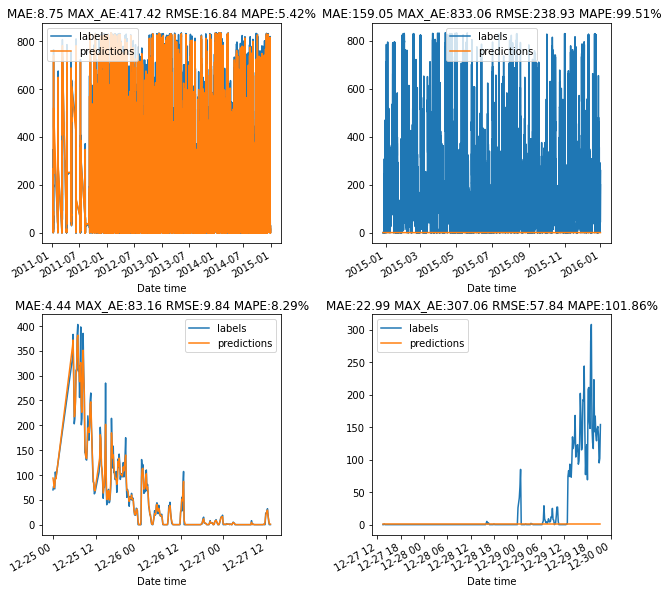

In [35]:

def train_forest(df, split_point):
  train_features = df.drop(['Power avg'], axis = 1).head(len(df)-split_point)   #Get rid of the 'Power avg' columns inc. column heading and keep all rows up to split_point
  train_labels = df['Power avg'].head(len(df)-split_point)                      #Just return 'Power avg' column without col heading up to split-point
  val_features = df.drop(['Power avg'], axis = 1).tail(split_point)             #Get rid of the 'Power avg' columns inc. column heading and keep all rows after split_point
  val_labels = df['Power avg'].tail(split_point)                                #Just return 'Power avg' column without col heading after split-point

  rf = RandomForestRegressor(n_estimators = 50, random_state = 42)
  rf.fit(train_features, train_labels)  #Train RF on training features (dates) and target classifcations / labels (power avg values)

  return [rf, train_features, train_labels, val_features, val_labels]

def check_predictions(rf, train_features, train_labels, val_features, val_labels):
  fig,axes  = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
  fig.tight_layout(pad=6.0)
  predictions_plot(rf, train_features, train_labels, axes[0,0]) #Predictions based on the training set of dates (should be v accurate)
  predictions_plot(rf, val_features, val_labels, axes[0,1]) #Predictions based on the test set of dates (should be quite inaccurate)
  predictions_plot(rf, train_features.tail(7*48), train_labels.tail(7*48), axes[1,0]) #Predictions based on the final week of training set of dates (should be v accurate)
  predictions_plot(rf, val_features.head(7*48), val_labels.head(7*48), axes[1,1]) #Predictions based on the first week of test set of dates (should be quite inaccurate)

def predictions_plot(rf, features, labels, ax):
  EPSILON =  1e-10  #1e-10 - Very small constant added to every entry to ensure no values of actual zero - this avoids zero division error on calculation of MAPE
  predictions = rf.predict(features) # Each call to this function just gives a set of features (dates) as a param and returns a dataframe of 'labels' (power avg values)
  errors = abs(predictions - labels) #predicted values numpy array minus actual values numpy array returns numpy array 'errors'
  
  #Figuring out MAPE:
  """ 
  print("Labels plus EPSILON: ", labels[:5]+EPSILON)
  print("Mean of Labels plus EPSILON: ", np.mean(labels[:5]+EPSILON))
  print("predictions: /n", predictions[:5])
  print("Errors: /n" , errors[:5])
  print("Labels: /n" , labels[:5])
  #print("errors / abs(labels)/n" , errors[:5]/abs(labels[:5]))
  #print("Mean of errors / abs(labels)/n" , np.mean(errors[:5]/abs(labels[:5])))
  #print("As a %: Mean of errors / abs(labels)/n" , np.mean(errors[:5]/abs(labels[:5]))*100)
  print("As a %: Mean of errors / abs(labels)/n" , np.mean(errors[:5]/abs(labels[:5])+EPSILON)*100)
  print("Rounded As a %: Mean of errors / abs(labels)/n" , round(np.mean(errors[:5]/abs(labels[:5])+EPSILON)*100,2))
  """

  # MAE = mean abs error; MAX_AE = max absolute error (largest single error in prediction by rf); RMSE = Root Mean Square Error (gets rid of negatives and more sensitive to large errors than MAPE);
  # MAPE = mean absolute percentage error (MAPE is a straightforward measure of the prediction accuracy of a forecasting method, and is thus usually considered as the fairest indicator https://www.mdpi.com/2071-1050/12/6/2247/htm#B37-sustainability-12-02247)
  title='MAE:' + str(round(np.mean(errors), 2)) + \
        ' MAX_AE:' + str(round(np.max(abs(errors)), 2)) + \
        ' RMSE:' + str(round(np.sqrt(np.mean(np.square(errors))), 2)) + \
        ' MAPE:' + str(round(((np.mean(errors)/np.mean((abs(labels+EPSILON))))*100),2)) + "%" # https://www.mdpi.com/2071-1050/12/6/2247/htm  Doesn't really work when you have zero values, which we do because sometimes the wind doesn't blow

  #Create dataframe comprising three elements: 'labels' (actual Power avg values), 'predictions' (predicted 'power avg' values), 'features' (Date time values) and then plot them
  pd.DataFrame({'labels': labels, 
                'predictions': predictions, 
                'Date time': features['Date time']}).plot(title=title, ax=ax, x='Date time')
                
[rf, train_features, train_labels, val_features, val_labels] = train_forest(df, 365*144) #The last year's worth of entries are reserved as a validation set (144 entries per day * 365 days)
check_predictions(rf, train_features, train_labels, val_features, val_labels) 

"The results are almost perfect on the training set, but the Random Forest is a flat line in the validation set because the decision trees can't extrapolate a datetime." - taken from 

In [ ]:
"""
abs_errors = abs(rf.predict(val_features.drop(['Power avg'], axis = 1)) - val_labels)
worst_index = abs_errors.tolist().index(max(abs_errors))
fig,axes  = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
predictions_plot(rf, val_features.head(worst_index + 3*48).tail(7*48), val_labels.head(worst_index + 3*48).tail(7*48), axes)
"""

"\nabs_errors = abs(rf.predict(val_features.drop(['Power avg'], axis = 1)) - val_labels)\nworst_index = abs_errors.tolist().index(max(abs_errors))\nfig,axes  = plt.subplots(nrows=1, ncols=1, figsize=(6,6))\npredictions_plot(rf, val_features.head(worst_index + 3*48).tail(7*48), val_labels.head(worst_index + 3*48).tail(7*48), axes)\n"